## Сбор данных (создание веб-краулера)

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import traceback

cookies = {
    'news_lang': 'ru',
    'nc': 'tips=1669116675432%3Bfavorites-button:1',
    'sso_checked': '1',
    'yandex_login': '',
    'yandexuid': '4418883751668766953',
    '_yasc': 'bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=',
    '_ym_uid': '16687727324320845',
    '_ym_d': '1668772732',
    'vid': 'c4a038b4868be81c',
    'Session_id': 'noauth:1669019784',
    'mda2_beacon': '1669019784785',
    '_ym_isad': '2',
    'tmr_lvid': '52390132f1b93bbd91c4c20fb582a7b7',
    'tmr_lvidTS': '1668772731725',
    'tmr_detect': '0%7C1669277547765',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    # Requests sorts cookies= alphabetically
    # 'Cookie': 'news_lang=ru; nc=tips=1669116675432%3Bfavorites-button:1; sso_checked=1; yandex_login=; yandexuid=4418883751668766953; _yasc=bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=; _ym_uid=16687727324320845; _ym_d=1668772732; vid=c4a038b4868be81c; Session_id=noauth:1669019784; mda2_beacon=1669019784785; _ym_isad=2; tmr_lvid=52390132f1b93bbd91c4c20fb582a7b7; tmr_lvidTS=1668772731725; tmr_detect=0%7C1669277547765',
    'Referer': 'https://dzen.ru/news?issue_tld=ru',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
}

# Функция для обработки и вывода времени
def parse_date(s_date):
    months = {'января': '01',
              'февраля': '02',
              'марта': '03',
              'апреля': '04',
              'мая': '05',
              'июня': '06',
              'июля': '07',
              'августа': '08',
              'сентября': '09',
              'октября': '10',
              'ноября': '11',
              'декабря': '12',
              }
    
    row_date = s_date.split(' в')[0]
    #print(row_date)
    month_ = row_date.split(' ')[1].strip(' ')
    date_num = re.search(r'\d{2}', row_date).group(0)
    date = f"{date_num}.{months[month_]}.2022"
    return date

### Сбор новостей по рубрикам (на сайте Яндекс Дзен)

In [2]:
def parse_rubrics():
    rubrics = ['Политика', 'Общество', 'Экономика', 'В мире', 'Спорт', 'Происшествия', 'Культура', 'Технологии', 'Наука']
    rubrics_links = ['rubric/politics', 'rubric/society', 'rubric/business', 'rubric/world', 'rubric/sport', 'rubric/incident', 'rubric/culture', 'rubric/computers', 'rubric/science']

    rubricsAndLinks = list(zip(rubrics, rubrics_links))
    df_rubricsAndLinks = pd.DataFrame(rubricsAndLinks, columns=['rubric', 'rubric_link'])

    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    dates = []
    times = []
    data = []
    stories = []

    for i, row in df_rubricsAndLinks.iterrows():
        link = row['rubric_link']
        r = session.get(f'https://dzen.ru/news/{link}?issue_tld=ru')

        soup = BeautifulSoup(r.text)
        script_text = soup.find_all('script')[3].contents[0]
        data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", script_text, flags=re.S).group(1))

        story_rubric = row['rubric']
    
        for stories_top in data['news']['top']:
        
            story_id = stories_top['id']
            story_title = stories_top['title']
            story_annotation = stories_top['annotation']
            story_url = stories_top['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_top['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
        for stories_feed in data['news']['feed']:
        
            story_id = stories_feed['id']
            story_title = stories_feed['title']
            story_annotation = stories_feed['annotation']
            story_url = stories_feed['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_feed['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
    
    story_headers = ['rubric', 'id', 'title', 'annotation', 'story_url', 'instory_url', 'time']
    df_stories = pd.DataFrame(stories, columns=story_headers)

    return df_stories

#parse_rubrics()

### Сбор похожих новостей при переходе к каждой новости (на сайте Яндекс Дзен)

In [3]:
def parse_main():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
        
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)

    return df_more_stories

#parse_main()

### Сохранение и чтение данных в формате xlsx

In [4]:
df1 = parse_main()

# Для mac
df1.to_excel(r'/Users/user/Documents/Книга1.xlsx')

# Для win
#df1.to_excel(r'C:\Users\User\Downloads\Книга1.xlsx')

In [5]:
# Для mac
df2 = pd.read_excel(r'/Users/user/Documents/Книга1.xlsx')

# Для win
#df2 = pd.read_excel(r'C:\Users\User\Downloads\Книга1.xlsx')

# Выражение, добавляющее к БД только новые новости
res = df1[~df1['url'].isin(df2['url'])]

#res
#df1

## Разведочный анализ данных EDA

In [6]:
# Объем данных (строк и столбцов - объектов и признаков)
df1.shape

(1364, 8)

In [7]:
# Вывод типов данных
df1.dtypes

rubric         object
story_id       object
title          object
text           object
sourceName     object
instory_url    object
url            object
time           object
dtype: object

<div class="alert alert-success"><b>Целевой признак - rubric</b>

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364 entries, 0 to 1363
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rubric       1364 non-null   object
 1   story_id     1364 non-null   object
 2   title        1364 non-null   object
 3   text         1364 non-null   object
 4   sourceName   1364 non-null   object
 5   instory_url  1364 non-null   object
 6   url          1364 non-null   object
 7   time         1364 non-null   object
dtypes: object(8)
memory usage: 85.4+ KB


<div class="alert alert-success"><b>Пропусков в данных нет</b>

In [9]:
# Имена колонок в виде списков
df1.columns

Index(['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url',
       'url', 'time'],
      dtype='object')

In [10]:
# Кол-во пропусков во всем датафрейме
df1.isnull().sum()

rubric         0
story_id       0
title          0
text           0
sourceName     0
instory_url    0
url            0
time           0
dtype: int64

In [11]:
# Статистика распределения этих значений в % виде
df1['rubric'].value_counts(normalize=True)

Происшествия    0.264663
Спорт           0.107771
Общество        0.101906
Политика        0.099707
В мире          0.095308
Экономика       0.090909
Культура        0.085044
Технологии      0.080645
Наука           0.074047
Name: rubric, dtype: float64

In [12]:
# Исследование целевого (target) признака - рубрики 
print('Кол-во уникальных значений: ', df1['rubric'].nunique())
print('Список уникальных значений: ', df1['rubric'].unique())
print('Статистика распределения значений: ', df1['rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  9
Список уникальных значений:  ['Политика' 'Общество' 'Экономика' 'В мире' 'Спорт' 'Происшествия'
 'Культура' 'Технологии' 'Наука']
Статистика распределения значений:  Происшествия    361
Спорт           147
Общество        139
Политика        136
В мире          130
Экономика       124
Культура        116
Технологии      110
Наука           101
Name: rubric, dtype: int64


<div class="alert alert-success"><b>Вывод: вид задачи - многоклассовая классификация</b>

In [13]:
# Описательная статистика для признака rubric
df1['rubric'].describe()

count             1364
unique               9
top       Происшествия
freq               361
Name: rubric, dtype: object

In [14]:
# Описательная статистика для всех признаков 
df1.describe().T

,count,unique,top,freq
rubric,1364,9,Происшествия,361
story_id,1364,250,833760675,61
title,1364,1285,Инфляция в Казахстане достигла исторического м...,3
text,1364,1299,"Автобус, следовавший по маршруту №509 ""Карпинс...",3
sourceName,1364,449,Газета.Ru,30
instory_url,1364,261,https://dzen.ru/news/instory/VNovosibirskoj_ob...,61
url,1364,1311,https://www.mk.ru/politics/2022/12/12/v-yaponi...,2
time,1364,615,12.12.2022 10:31,22


### Визульный анализ

<AxesSubplot:>

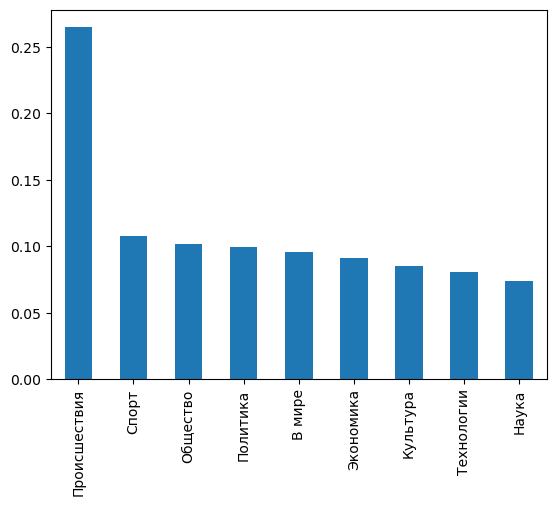

In [15]:
# Столбчатая диаграмма
# По оси y - доля в %, по x - сами рубрики
# Если поменять normalize=True на normalize=False, то ось y будет в кол-ом значении

df1['rubric'].value_counts(normalize=True).plot.bar()

<AxesSubplot:ylabel='rubric'>

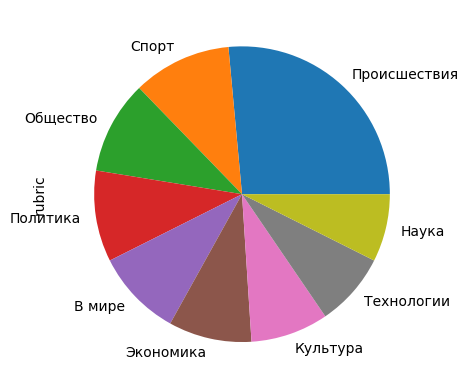

In [16]:
# Круговая(пирожковая) диаграмма
df1['rubric'].value_counts(normalize=True).plot.pie()

<AxesSubplot:>

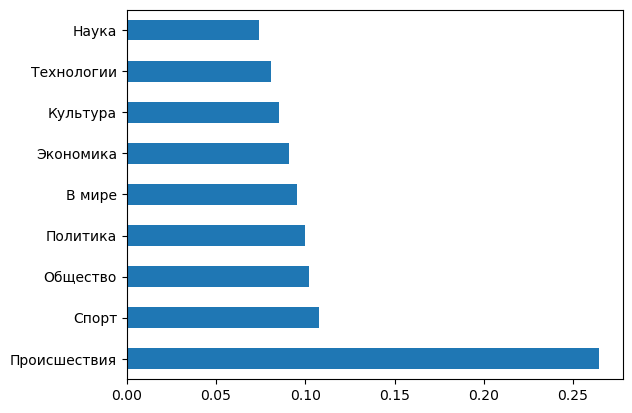

In [17]:
# Горизонтальная столбчатая диаграмма
df1['rubric'].value_counts(normalize=True).plot.barh()

In [18]:
df1['rubric'].value_counts()

Происшествия    361
Спорт           147
Общество        139
Политика        136
В мире          130
Экономика       124
Культура        116
Технологии      110
Наука           101
Name: rubric, dtype: int64

## Предварительная обработка данных (preprocessing). Обработка естественного языка NLP


Действия, выполняемые в процессе:
* сегментация и токенизация;
* стемминг;
* удаление стоп-слов;
* лемматизация.

### Удаление пробельных символов

In [27]:
import string
import re
from nltk.corpus import stopwords

def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

def delete_char(): 
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df1['text']]
    df_nlp = df1.loc[:, ['rubric','title','text']]
    df_nlp["text_prep"] = prep_text
    return df_nlp

df_nlp = delete_char()

df_nlp

,rubric,title,text,text_prep
0,Политика,"Президент Зеленский пожаловался Байдену, об ун...",На сайте украинского лидера опубликован пресс-...,на сайте украинского лидера опубликован пресс ...
1,Политика,Зеленский в беседе с Байденом заявил об уничто...,Президент Украины Владимир Зеленский заявил в ...,президент украины владимир зеленский заявил в ...
2,Политика,Зеленский сообщил Байдену об уничтожении полов...,«Зеленский проинформировал Байдена о последств...,«зеленский проинформировал байдена о последств...
3,Политика,Зеленский сообщил Байдену об уничтожении 50% э...,Владимир Зеленский в телефонном разговоре с ли...,владимир зеленский в телефонном разговоре с ли...
4,Политика,Зеленский сообщил Байдену об уничтожении 50% и...,Российские ракетные удары уничтожили 50% инфра...,российские ракетные удары уничтожили инфрастру...
...,...,...,...,...
1359,Наука,Учёные нашли прорывной метод лечения лимфомы ц...,Американские исследователи подтвердили эффекти...,американские исследователи подтвердили эффекти...
1360,Наука,EurekAlert: новая терапия рака крови показывае...,Успех иммунотерапии был отмечен даже у пациент...,успех иммунотерапии был отмечен даже у пациент...
1361,Наука,Новая терапия онкологии крови показала успех в...,Экспериментальная группа ученых получила полож...,экспериментальная группа ученых получила полож...
1362,Наука,EurekAlert: новая терапия рака крови показывае...,Международная группа учёных протестировала нов...,международная группа учёных протестировала нов...


### Стемминг

In [30]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

def stemmed_text():
    stemmer = SnowballStemmer("russian")
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])

    stemmed_texts_list = []
    for text in df_nlp["text_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_texts_list.append(text)
    
    df_nlp["text_stem"] = stemmed_texts_list
    return df_nlp

stemmed_text()

,rubric,title,text,text_prep,text_stem
0,Политика,"Президент Зеленский пожаловался Байдену, об ун...",На сайте украинского лидера опубликован пресс-...,на сайте украинского лидера опубликован пресс ...,сайт украинск лидер опубликова пресс релиз кот...
1,Политика,Зеленский в беседе с Байденом заявил об уничто...,Президент Украины Владимир Зеленский заявил в ...,президент украины владимир зеленский заявил в ...,президент украин владимир зеленск заяв бесед а...
2,Политика,Зеленский сообщил Байдену об уничтожении полов...,«Зеленский проинформировал Байдена о последств...,«зеленский проинформировал байдена о последств...,зеленск проинформирова байд последств российск...
3,Политика,Зеленский сообщил Байдену об уничтожении 50% э...,Владимир Зеленский в телефонном разговоре с ли...,владимир зеленский в телефонном разговоре с ли...,владимир зеленск телефон разговор лидер сша дж...
4,Политика,Зеленский сообщил Байдену об уничтожении 50% и...,Российские ракетные удары уничтожили 50% инфра...,российские ракетные удары уничтожили инфрастру...,российск ракетн удар уничтож инфраструктур укр...
...,...,...,...,...,...
1359,Наука,Учёные нашли прорывной метод лечения лимфомы ц...,Американские исследователи подтвердили эффекти...,американские исследователи подтвердили эффекти...,американск исследовател подтверд эффективн без...
1360,Наука,EurekAlert: новая терапия рака крови показывае...,Успех иммунотерапии был отмечен даже у пациент...,успех иммунотерапии был отмечен даже у пациент...,успех иммунотерап отмеч пациент че рак устойч ...
1361,Наука,Новая терапия онкологии крови показала успех в...,Экспериментальная группа ученых получила полож...,экспериментальная группа ученых получила полож...,экспериментальн групп учен получ положительн р...
1362,Наука,EurekAlert: новая терапия рака крови показывае...,Международная группа учёных протестировала нов...,международная группа учёных протестировала нов...,международн групп учен протестирова нов метод ...


### Удаление стоп-слов

In [32]:
from nltk import word_tokenize

def stopword_text():
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    
    sw_texts_list = []
    for text in df_nlp['text_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_texts_list.append(text)

    df_nlp["text_sw"] = sw_texts_list
    return df_nlp

stopword_text()

,rubric,title,text,text_prep,text_stem,text_sw
0,Политика,"Президент Зеленский пожаловался Байдену, об ун...",На сайте украинского лидера опубликован пресс-...,на сайте украинского лидера опубликован пресс ...,сайт украинск лидер опубликова пресс релиз кот...,сайте украинского лидера опубликован пресс рел...
1,Политика,Зеленский в беседе с Байденом заявил об уничто...,Президент Украины Владимир Зеленский заявил в ...,президент украины владимир зеленский заявил в ...,президент украин владимир зеленск заяв бесед а...,президент украины владимир зеленский заявил бе...
2,Политика,Зеленский сообщил Байдену об уничтожении полов...,«Зеленский проинформировал Байдена о последств...,«зеленский проинформировал байдена о последств...,зеленск проинформирова байд последств российск...,зеленский проинформировал байдена последствиях...
3,Политика,Зеленский сообщил Байдену об уничтожении 50% э...,Владимир Зеленский в телефонном разговоре с ли...,владимир зеленский в телефонном разговоре с ли...,владимир зеленск телефон разговор лидер сша дж...,владимир зеленский телефонном разговоре лидеро...
4,Политика,Зеленский сообщил Байдену об уничтожении 50% и...,Российские ракетные удары уничтожили 50% инфра...,российские ракетные удары уничтожили инфрастру...,российск ракетн удар уничтож инфраструктур укр...,российские ракетные удары уничтожили инфрастру...
...,...,...,...,...,...,...
1359,Наука,Учёные нашли прорывной метод лечения лимфомы ц...,Американские исследователи подтвердили эффекти...,американские исследователи подтвердили эффекти...,американск исследовател подтверд эффективн без...,американские исследователи подтвердили эффекти...
1360,Наука,EurekAlert: новая терапия рака крови показывае...,Успех иммунотерапии был отмечен даже у пациент...,успех иммунотерапии был отмечен даже у пациент...,успех иммунотерап отмеч пациент че рак устойч ...,успех иммунотерапии отмечен пациентов чей рак ...
1361,Наука,Новая терапия онкологии крови показала успех в...,Экспериментальная группа ученых получила полож...,экспериментальная группа ученых получила полож...,экспериментальн групп учен получ положительн р...,экспериментальная группа ученых получила полож...
1362,Наука,EurekAlert: новая терапия рака крови показывае...,Международная группа учёных протестировала нов...,международная группа учёных протестировала нов...,международн групп учен протестирова нов метод ...,международная группа учёных протестировала нов...


### Лемматизация

In [35]:
from pymystem3 import Mystem

def lemmatize_text():
    mystem = Mystem()
    lemm_texts_list = []
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    text = ""

    text_list = df_nlp['text_sw'].to_list()
    text_join = "joining".join(text_list)

    try:
        text_lem = mystem.lemmatize(text_join)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
    except Exception as e:
        print(e)

    text_split = text.split("joining")
    df_nlp["text_lemm"] = text_split
    return df_nlp

lemmatize_text()

,rubric,title,text,text_prep,text_stem,text_sw,text_lemm
0,Политика,"Президент Зеленский пожаловался Байдену, об ун...",На сайте украинского лидера опубликован пресс-...,на сайте украинского лидера опубликован пресс ...,сайт украинск лидер опубликова пресс релиз кот...,сайте украинского лидера опубликован пресс рел...,сайт украинский лидер опубликовывать пресс рел...
1,Политика,Зеленский в беседе с Байденом заявил об уничто...,Президент Украины Владимир Зеленский заявил в ...,президент украины владимир зеленский заявил в ...,президент украин владимир зеленск заяв бесед а...,президент украины владимир зеленский заявил бе...,президент украина владимир зеленский заявлять ...
2,Политика,Зеленский сообщил Байдену об уничтожении полов...,«Зеленский проинформировал Байдена о последств...,«зеленский проинформировал байдена о последств...,зеленск проинформирова байд последств российск...,зеленский проинформировал байдена последствиях...,зеленский проинформировать байден последствие ...
3,Политика,Зеленский сообщил Байдену об уничтожении 50% э...,Владимир Зеленский в телефонном разговоре с ли...,владимир зеленский в телефонном разговоре с ли...,владимир зеленск телефон разговор лидер сша дж...,владимир зеленский телефонном разговоре лидеро...,владимир зеленский телефонный разговор лидер с...
4,Политика,Зеленский сообщил Байдену об уничтожении 50% и...,Российские ракетные удары уничтожили 50% инфра...,российские ракетные удары уничтожили инфрастру...,российск ракетн удар уничтож инфраструктур укр...,российские ракетные удары уничтожили инфрастру...,российские ракетный удар уничтожать инфраструк...
...,...,...,...,...,...,...,...
1359,Наука,Учёные нашли прорывной метод лечения лимфомы ц...,Американские исследователи подтвердили эффекти...,американские исследователи подтвердили эффекти...,американск исследовател подтверд эффективн без...,американские исследователи подтвердили эффекти...,американские исследователь подтверждать эффект...
1360,Наука,EurekAlert: новая терапия рака крови показывае...,Успех иммунотерапии был отмечен даже у пациент...,успех иммунотерапии был отмечен даже у пациент...,успех иммунотерап отмеч пациент че рак устойч ...,успех иммунотерапии отмечен пациентов чей рак ...,успех иммунотерапия отмечать пациент чей рак у...
1361,Наука,Новая терапия онкологии крови показала успех в...,Экспериментальная группа ученых получила полож...,экспериментальная группа ученых получила полож...,экспериментальн групп учен получ положительн р...,экспериментальная группа ученых получила полож...,экспериментальная группа ученый получать полож...
1362,Наука,EurekAlert: новая терапия рака крови показывае...,Международная группа учёных протестировала нов...,международная группа учёных протестировала нов...,международн групп учен протестирова нов метод ...,международная группа учёных протестировала нов...,международная группа ученый протестировать нов...


In [43]:
def undersempler():
    df_pr = df_nlp.loc[df_nlp['rubric'] == 'Происшествия'].head(200)
    df_other = df_nlp.loc[df_nlp['rubric'] != 'Происшествия']

    df_ml = pd.concat([df_pr, df_other])
    return df_ml

df_ml = undersempler()
df_ml

,rubric,title,text,text_prep,text_stem,text_sw,text_lemm
676,Происшествия,В Балашихе загорелся ТЦ «Стройпарк»,Пожару пока что присвоен третий ранг сложности...,пожару пока что присвоен третий ранг сложности...,пожар пок присво трет ранг сложност – обознача...,пожару пока присвоен третий ранг сложности – о...,пожару пока присваивать третий ранг сложность ...
677,Происшествия,В России снова загорелся крупный торговый цент...,В подмосковной Балашихе в микрорайоне Саввино ...,в подмосковной балашихе в микрорайоне саввино ...,подмосковн балаших микрорайон саввин гор торго...,подмосковной балашихе микрорайоне саввино гори...,подмосковной балашиха микрорайон саввина горет...
678,Происшествия,Площадь возгорания в подмосковном ТЦ «Стройпар...,"Площадь пожара в ТЦ ""Стройпарк"" в подмосковной...",площадь пожара в тц стройпарк в подмосковной б...,площад пожар тц стройпарк подмосковн балаших у...,площадь пожара тц стройпарк подмосковной балаш...,площадь пожар тц стройпарк подмосковный балаши...
679,Происшествия,Пожару на территории ТЦ «Стройтракт» присвоен ...,Пожару на территории ТЦ «Стройтракт» присвоен ...,пожару на территории тц «стройтракт» присвоен ...,пожар территор тц стройтракт присво ранг сложност,пожару территории тц стройтракт присвоен ранг ...,пожару территория тц стройтракт присваивать ра...
680,Происшествия,В Подмосковье вновь загорелся крупный торговый...,12 декабря в Подмосковье загорелся еще один то...,декабря в подмосковье загорелся еще один торг...,декабр подмосков загорел торгов центр – магази...,декабря подмосковье загорелся торговый центр –...,декабря подмосковье загораться торговый центр ...
...,...,...,...,...,...,...,...
1359,Наука,Учёные нашли прорывной метод лечения лимфомы ц...,Американские исследователи подтвердили эффекти...,американские исследователи подтвердили эффекти...,американск исследовател подтверд эффективн без...,американские исследователи подтвердили эффекти...,американские исследователь подтверждать эффект...
1360,Наука,EurekAlert: новая терапия рака крови показывае...,Успех иммунотерапии был отмечен даже у пациент...,успех иммунотерапии был отмечен даже у пациент...,успех иммунотерап отмеч пациент че рак устойч ...,успех иммунотерапии отмечен пациентов чей рак ...,успех иммунотерапия отмечать пациент чей рак у...
1361,Наука,Новая терапия онкологии крови показала успех в...,Экспериментальная группа ученых получила полож...,экспериментальная группа ученых получила полож...,экспериментальн групп учен получ положительн р...,экспериментальная группа ученых получила полож...,экспериментальная группа ученый получать полож...
1362,Наука,EurekAlert: новая терапия рака крови показывае...,Международная группа учёных протестировала нов...,международная группа учёных протестировала нов...,международн групп учен протестирова нов метод ...,международная группа учёных протестировала нов...,международная группа ученый протестировать нов...


<AxesSubplot:>

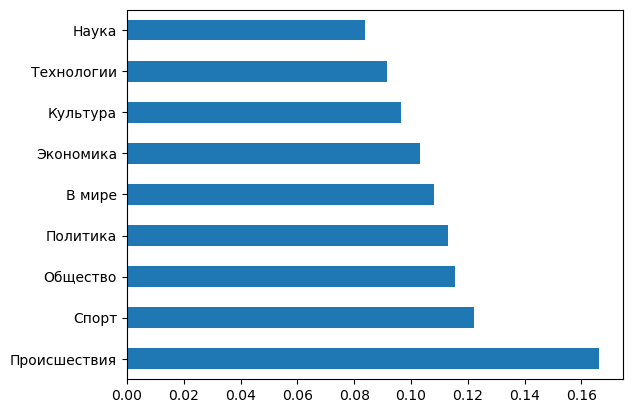

In [44]:
# Горизонтальная столбчатая диаграмма
df_ml['rubric'].value_counts(normalize=True).plot.barh()

## Создание моделей машинного обучения

### Кодирование целевой переменной. Формирование тестовой и обучающей выборок

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

rubrics = ['Политика', 'Общество', 'Экономика', 'В мире', 'Спорт', 'Происшествия', 'Культура', 'Технологии', 'Наука']

encoder = LabelEncoder()
rubrics_list = df_ml['rubric'].to_list()
rubric_labels = encoder.fit_transform(rubrics_list)

X = df_ml['text_lemm']
#X = df_nlp['text_sw']
y = rubric_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
my_tags = rubrics

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Байесовский классификатор

In [47]:
from sklearn.naive_bayes import MultinomialNB

def nb_classifier():
    
    nb = Pipeline ([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
                   ])

    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

nb_classifier()

accuracy 0.7950138504155124
              precision    recall  f1-score   support

    Политика       0.62      0.57      0.59        37
    Общество       0.97      0.77      0.86        39
   Экономика       0.83      0.75      0.79        20
      В мире       1.00      0.61      0.76        44
       Спорт       0.83      0.81      0.82        47
Происшествия       0.62      1.00      0.77        57
    Культура       0.90      1.00      0.95        45
  Технологии       0.77      0.69      0.73        29
       Наука       0.92      0.79      0.85        43

    accuracy                           0.80       361
   macro avg       0.83      0.78      0.79       361
weighted avg       0.82      0.80      0.79       361



0.8

### Метод опорных векторов

In [48]:
from sklearn.linear_model import SGDClassifier

def sgd_classifier():
    
    sgd = Pipeline ([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                    ])

    sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

sgd_classifier()

accuracy 0.850415512465374
              precision    recall  f1-score   support

    Политика       0.61      0.54      0.57        37
    Общество       0.95      0.90      0.92        39
   Экономика       0.78      0.90      0.84        20
      В мире       0.95      0.80      0.86        44
       Спорт       0.86      0.81      0.84        47
Происшествия       0.95      0.98      0.97        57
    Культура       0.98      0.98      0.98        45
  Технологии       0.71      0.83      0.76        29
       Наука       0.76      0.86      0.80        43

    accuracy                           0.85       361
   macro avg       0.84      0.84      0.84       361
weighted avg       0.85      0.85      0.85       361



0.85

### Логистическая регрессия

In [49]:
from sklearn.linear_model import LogisticRegression

def logreg_classifier():

    logreg = Pipeline ([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                       ])

    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

logreg_classifier()

accuracy 0.8448753462603878
              precision    recall  f1-score   support

    Политика       0.57      0.54      0.56        37
    Общество       0.94      0.87      0.91        39
   Экономика       0.78      0.90      0.84        20
      В мире       0.92      0.80      0.85        44
       Спорт       0.84      0.81      0.83        47
Происшествия       0.95      1.00      0.97        57
    Культура       0.94      0.98      0.96        45
  Технологии       0.74      0.79      0.77        29
       Наука       0.78      0.84      0.81        43

    accuracy                           0.84       361
   macro avg       0.83      0.84      0.83       361
weighted avg       0.85      0.84      0.84       361



/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.84

### Дерево решений 

In [50]:
from sklearn.tree import DecisionTreeClassifier

def dtree_classifier():
    
    dtree = Pipeline ([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('clf', DecisionTreeClassifier(max_depth = 2)),
                      ])

    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

dtree_classifier()

accuracy 0.20498614958448755
              precision    recall  f1-score   support

    Политика       0.00      0.00      0.00        37
    Общество       0.00      0.00      0.00        39
   Экономика       0.00      0.00      0.00        20
      В мире       0.00      0.00      0.00        44
       Спорт       0.00      0.00      0.00        47
Происшествия       0.17      1.00      0.28        57
    Культура       1.00      0.38      0.55        45
  Технологии       0.00      0.00      0.00        29
       Наука       0.00      0.00      0.00        43

    accuracy                           0.20       361
   macro avg       0.13      0.15      0.09       361
weighted avg       0.15      0.20      0.11       361



/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.2

### Метод K ближайщих соседей KNN

#### Для n_neighbors=3

In [51]:
from sklearn.neighbors import KNeighborsClassifier

def knn3_classifier():

    knn3 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', KNeighborsClassifier(n_neighbors=3)),
                   ])

    knn3.fit(X_train, y_train)
    y_pred = knn3.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

knn3_classifier()

accuracy 0.814404432132964
              precision    recall  f1-score   support

    Политика       0.57      0.62      0.60        37
    Общество       0.85      0.87      0.86        39
   Экономика       0.61      0.95      0.75        20
      В мире       0.84      0.70      0.77        44
       Спорт       0.84      0.79      0.81        47
Происшествия       0.93      0.91      0.92        57
    Культура       0.93      0.96      0.95        45
  Технологии       0.74      0.69      0.71        29
       Наука       0.88      0.81      0.84        43

    accuracy                           0.81       361
   macro avg       0.80      0.81      0.80       361
weighted avg       0.82      0.81      0.82       361



0.81

#### Для n_neighbors=9

In [52]:
from sklearn.neighbors import KNeighborsClassifier

def knn9_classifier():
    
    knn9 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', KNeighborsClassifier(n_neighbors=9)),
                   ])

    knn9.fit(X_train, y_train)
    y_pred = knn9.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

knn9_classifier()

accuracy 0.7811634349030471
              precision    recall  f1-score   support

    Политика       0.53      0.65      0.59        37
    Общество       0.87      0.85      0.86        39
   Экономика       0.67      0.90      0.77        20
      В мире       0.74      0.57      0.64        44
       Спорт       0.80      0.77      0.78        47
Происшествия       0.86      0.89      0.88        57
    Культура       0.91      0.96      0.93        45
  Технологии       0.77      0.69      0.73        29
       Наука       0.80      0.74      0.77        43

    accuracy                           0.78       361
   macro avg       0.77      0.78      0.77       361
weighted avg       0.79      0.78      0.78       361



0.78

### Метод градиентного бустинга

In [53]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score 

def gbr_classifier():
    
    gbr = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', GradientBoostingRegressor(n_estimators=200, max_depth=12, criterion='squared_error', learning_rate=0.03, min_samples_leaf=16, min_samples_split=16)),
                   ])

    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    train_accuracy_score=gbr.score(X_train,y_train)
    test_accuracy_score=gbr.score(X_test,y_test)
    mse = mean_squared_error(y_test,y_pred)

    print(train_accuracy_score)
    print(test_accuracy_score)
    print("MSE: %.2f" % mse)
    print(r2_score(y_test,y_pred))
    
    return round(test_accuracy_score, 2)

gbr_classifier()

0.39830693338151346
0.0943692962066951
MSE: 5.63
0.0943692962066951


0.09

In [54]:
from sklearn.metrics import confusion_matrix

cm = multilabel_confusion_matrix(y_test,y_pred, labels=rubrics)
cm

NameError: name 'multilabel_confusion_matrix' is not defined

![jupyter](https://pythonru.com/wp-content/uploads/2021/03/matrica-oshibok-dlya-binarnoj-klassifikacii.png)

True, если получено верное предсказание, то есть эталонные и предсказанные метки классов совпадают, и False, когда они не совпадают. Positive или Negative — названия предсказанных меток.

In [ ]:
# Пример рассчета характеристик для конкретного класса

# Чувствительность (recall)
print('TPR = %.2f' % (cm[1][1] / sum(cm[1])))

# Специфичность
print('SPC = %.2f' % (cm[0][0] / sum(cm[0])))

# Ценность + прогноза (precision)
print('PPV = %.2f' % (cm[1][1] / sum(col[1] for col in cm)))

# Ценность - прогноза
print('NPV = %.2f' % (cm[0][0] / sum(col[0] for col in cm)))

print('Acc = %.2f' % ((cm[0][0] + cm[1][1]) / sum(cm[0][])))

In [91]:
df_ml

,rubric,title,text,text_prep,text_stem,text_sw,text_lemm
676,Происшествия,В Балашихе загорелся ТЦ «Стройпарк»,Пожару пока что присвоен третий ранг сложности...,пожару пока что присвоен третий ранг сложности...,пожар пок присво трет ранг сложност – обознача...,пожару пока присвоен третий ранг сложности – о...,пожару пока присваивать третий ранг сложность ...
677,Происшествия,В России снова загорелся крупный торговый цент...,В подмосковной Балашихе в микрорайоне Саввино ...,в подмосковной балашихе в микрорайоне саввино ...,подмосковн балаших микрорайон саввин гор торго...,подмосковной балашихе микрорайоне саввино гори...,подмосковной балашиха микрорайон саввина горет...
678,Происшествия,Площадь возгорания в подмосковном ТЦ «Стройпар...,"Площадь пожара в ТЦ ""Стройпарк"" в подмосковной...",площадь пожара в тц стройпарк в подмосковной б...,площад пожар тц стройпарк подмосковн балаших у...,площадь пожара тц стройпарк подмосковной балаш...,площадь пожар тц стройпарк подмосковный балаши...
679,Происшествия,Пожару на территории ТЦ «Стройтракт» присвоен ...,Пожару на территории ТЦ «Стройтракт» присвоен ...,пожару на территории тц «стройтракт» присвоен ...,пожар территор тц стройтракт присво ранг сложност,пожару территории тц стройтракт присвоен ранг ...,пожару территория тц стройтракт присваивать ра...
680,Происшествия,В Подмосковье вновь загорелся крупный торговый...,12 декабря в Подмосковье загорелся еще один то...,декабря в подмосковье загорелся еще один торг...,декабр подмосков загорел торгов центр – магази...,декабря подмосковье загорелся торговый центр –...,декабря подмосковье загораться торговый центр ...
...,...,...,...,...,...,...,...
1359,Наука,Учёные нашли прорывной метод лечения лимфомы ц...,Американские исследователи подтвердили эффекти...,американские исследователи подтвердили эффекти...,американск исследовател подтверд эффективн без...,американские исследователи подтвердили эффекти...,американские исследователь подтверждать эффект...
1360,Наука,EurekAlert: новая терапия рака крови показывае...,Успех иммунотерапии был отмечен даже у пациент...,успех иммунотерапии был отмечен даже у пациент...,успех иммунотерап отмеч пациент че рак устойч ...,успех иммунотерапии отмечен пациентов чей рак ...,успех иммунотерапия отмечать пациент чей рак у...
1361,Наука,Новая терапия онкологии крови показала успех в...,Экспериментальная группа ученых получила полож...,экспериментальная группа ученых получила полож...,экспериментальн групп учен получ положительн р...,экспериментальная группа ученых получила полож...,экспериментальная группа ученый получать полож...
1362,Наука,EurekAlert: новая терапия рака крови показывае...,Международная группа учёных протестировала нов...,международная группа учёных протестировала нов...,международн групп учен протестирова нов метод ...,международная группа учёных протестировала нов...,международная группа ученый протестировать нов...


### Искусственные нейронные сети

In [97]:
encoder = LabelEncoder()
rubrics_list = df_ml['rubric'].to_list()
rubric_labels = encoder.fit_transform(rubrics_list)
X_data = df_ml['text_lemm'].to_list()

X = encoder.fit_transform(X_data)
y = rubric_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
my_tags = rubrics

array([ 666,  654,  649, ..., 1131,  441,  914])

In [99]:
import random
import numpy as np

INPUT_DIM = 1
OUT_DIM = 9
H_DIM = 5

#dataset = [(df_ml['text_lemm'][i][None, ...], df_ml['rubric'][i]) for i in range(len(df_ml['rubric']))]

W1 = np.random.rand(INPUT_DIM, H_DIM)
b1 = np.random.rand(1, H_DIM)
W2 = np.random.rand(H_DIM, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = (W1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
b1 = (b1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
W2 = (W2 - 0.5) * 2 * np.sqrt(1/H_DIM)
b2 = (b2 - 0.5) * 2 * np.sqrt(1/H_DIM)

#Функция активации
def relu(t):
    return np.maximum(t,0)

def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)

def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)

def sparse_cross_entropy(z,y):
    return -np.log(z[0,y])

def sparse_cross_entropy_batch(z,y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

def to_full(y, num_classes):
    y_full = np.zeros((1, num_classes))
    y_full[0, y] = 1
    return y_full

def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full

def relu_deriv(t):
    return (t >= 0).astype(float)

#Гиперпараметры нейросети
#Скорость обучения (Learning rate)
ALPHA = 0.001
#Количество эпох
NUM_EPOCHS = 100
#Размер батча
BATCH_SIZE = 1


loss_arr = []

for ep in range(NUM_EPOCHS):
    random.shuffle(dataset)
    for i in range(len(X_train) // BATCH_SIZE):
        #batch_x, batch_y = zip(*dataset[i*BATCH_SIZE : i*BATCH_SIZE+BATCH_SIZE])
        #x = np.concatenate(batch_x, axis=0)
        #y = np.array(batch_y)
        
        #Forward (прямое распространение)
        t1 = x @ W1 + b1
        h1 = relu(t1)
        t2 = h1 @ W2 + b2
        z = softmax_batch(t2)
        E = sparse_cross_entropy_batch(z,y)

        #Backward (обратное распространение)
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = h1.T @ dE_dt2
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = dE_dt2 @ W2.T
        dE_dt1 = dE_dh1 * relu_deriv(t1)
        dE_dW1 = x.T @ dE_dt1
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        #Update (обновление весов)
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2
        W1 = W1 - ALPHA * dE_dW1
        probs = predict(x)
        pred_class = np.argmax(probs)
        class_names = ['Политика', 'Общество', 'Экономика', 'В мире', 'Спорт', 'Происшествия', 'Культура', 'Технологии', 'Наука']

        #Метрика "зависимость ошибки от итерации"
        loss_arr.append(E)
        
        #Метрика "точность предсказания" ...
        
def predict(x):
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax_batch(t2)
    return z

def calc_accuracy():
    correct = 0
    for x,y in dataset:
        z = predict(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(dataset)
    return acc

accuracu = calc_accuracy()
print('Accuracy:', accuracy)

#График падения ошибки
import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 4)

In [74]:
import matplotlib.pyplot as plt